<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/Miniproyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Montar el Google Drive en el directorio del proyecto y descomprimir el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/vision-artificial.zip' >> /dev/null  # ACTUALIZAR: ruta al fichero comprimido


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.9 MB/s eta 0:00:00


In [17]:
# Especificar las rutas al directorio con las imágenes y al fichero con las etiquetas
imgtrain_dir = "/content/train/images/"
imgtrainmask_dir = "/content/train/masks/"
csvtrain_file = "/content/train.csv"

imgtest_dir = "/content/train.csv"
csvtest_file = "/content/test.csv"
# Leer el fichero CSV con las etiquetas
df = pd.read_csv(csvtrain_file, dtype={"class": "category"})
dftest = pd.read_csv(csvtest_file, dtype={"class": "category"})

# Codificar las etiquetas utilizando LabelEncoder
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

# Convertir las etiquetas codificadas en un vector one-hot
class_one_hot = pd.get_dummies(df['class_encoded'], prefix='class')

# Renombrar las columnas del vector one-hot
class_one_hot.columns = ['normal', 'benign', 'malignant']

# Concatenar el DataFrame original con las etiquetas one-hot y la columna 'mask_filename'
df = pd.concat([df[['image_filename', 'mask_filename']], class_one_hot], axis=1)

In [18]:
column_names = df.columns.tolist()
# Convertir las columnas 'normal', 'benign' y 'malignant' en un tensor booleano
print(df)
print(column_names[2:5])

    image_filename mask_filename  normal  benign  malignant
0    image_003.png  mask_003.png    True   False      False
1    image_004.png  mask_004.png    True   False      False
2    image_008.png  mask_008.png    True   False      False
3    image_012.png  mask_012.png    True   False      False
4    image_016.png  mask_016.png    True   False      False
..             ...           ...     ...     ...        ...
332  image_399.png  mask_399.png   False   False       True
333  image_400.png  mask_400.png   False   False       True
334  image_416.png  mask_416.png   False   False       True
335  image_419.png  mask_419.png   False   False       True
336  image_443.png  mask_443.png   False   False       True

[337 rows x 5 columns]
['normal', 'benign', 'malignant']


In [43]:
# Crear un diccionario para almacenar una instancia por clase
class_instances = {'normal': None, 'benign': None, 'malignant': None}

# Iterar sobre el DataFrame para encontrar una instancia por clase
for index, row in df.iterrows():
    image_path = os.path.join(imgtrain_dir, row['image_filename'])
    mask_path = os.path.join(imgtrainmask_dir, row['mask_filename'])
    labels = row[['normal', 'benign', 'malignant']]

    # Leer la imagen y la máscara
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=n_channels)
    image = tf.image.resize(image, [img_width, img_height])
    image = image / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [img_width, img_height])

    # Verificar si ya se ha encontrado una instancia para cada clase
    if class_instances['normal'] is None and labels[0]:
        class_instances['normal'] = (image.numpy(), mask.numpy(), labels)
    elif class_instances['benign'] is None and labels[1]:
        class_instances['benign'] = (image.numpy(), mask.numpy(), labels)
    elif class_instances['malignant'] is None and labels[2]:
        class_instances['malignant'] = (image.numpy(), mask.numpy(), labels)

    # Verificar si se han encontrado instancias para todas las clases
    if all(class_instances.values()):
        break

# Imprimir los valores de los elementos que no son cero en la matriz de la máscara
for class_name, (image, mask, labels) in class_instances.items():
    print(f"Clase: {class_name}")
    print("Etiqueta:")
    print(f"Normal: {labels[0]}, Benigno: {labels[1]}, Maligno: {labels[2]}")

    # Encontrar los índices de los elementos que no son cero en la matriz de la máscara
    non_zero_indices = np.argwhere(mask != 0)
    for index in non_zero_indices:
        value = mask[tuple(index)]
        print(f"Valor no nulo en posición {index}: {value}")

    print("-" * 50)




Se han truncado las últimas 5000 líneas del flujo de salida.
Valor no nulo en posición [128 100   0]: 255.0
Valor no nulo en posición [128 101   0]: 255.0
Valor no nulo en posición [128 102   0]: 255.0
Valor no nulo en posición [128 103   0]: 255.0
Valor no nulo en posición [128 104   0]: 255.0
Valor no nulo en posición [128 105   0]: 255.0
Valor no nulo en posición [128 106   0]: 255.0
Valor no nulo en posición [128 107   0]: 255.0
Valor no nulo en posición [128 108   0]: 255.0
Valor no nulo en posición [128 109   0]: 255.0
Valor no nulo en posición [128 110   0]: 255.0
Valor no nulo en posición [128 111   0]: 255.0
Valor no nulo en posición [128 112   0]: 255.0
Valor no nulo en posición [128 113   0]: 255.0
Valor no nulo en posición [128 114   0]: 255.0
Valor no nulo en posición [128 115   0]: 255.0
Valor no nulo en posición [128 116   0]: 255.0
Valor no nulo en posición [128 117   0]: 255.0
Valor no nulo en posición [128 118   0]: 255.0
Valor no nulo en posición [128 119   0]: 255.0

In [19]:
# Dividir el conjunto en entrenamiento, validación y test (80:10:10)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.2)

df = df.sample(frac=1).reset_index(drop=True)  # barajar el dataframe
dftest = df[:test_size]
dfval = df[test_size:test_size+val_size]
dftrain = df[test_size+val_size:]

print(f'Número de ejemplos del conjunto de entrenamiento: {dftrain.shape[0]}')
print(f'Número de ejemplos del conjunto de validación: {dfval.shape[0]}')
print(f'Número de ejemplos del conjunto de test: {dftest.shape[0]}')
dftrain = dftrain.reset_index(drop=True)
dfval = dfval.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)

Número de ejemplos del conjunto de entrenamiento: 203
Número de ejemplos del conjunto de validación: 67
Número de ejemplos del conjunto de test: 67


In [ ]:
archivos = os.listdir(imgtrain_dir)
anchuras = []
alturas = []
for archivo in archivos:
      imagen = Image.open(os.path.join(imgtrain_dir, archivo))
      ancho, alto = imagen.size
      anchuras.append(ancho)
      alturas.append(alto)
media_anchura = sum(anchuras) / len(anchuras)
media_altura = sum(alturas) / len(alturas)

print("Media de anchura:", media_anchura)
print("Media de altura:", media_altura)

Media de anchura: 634.9139465875371
Media de altura: 514.9317507418398


In [38]:
# Dimensiones deseadas de la imagen
img_width, img_height = 448,448
n_channels = 3                # número de canales (RGB)
n_classes = 3                 # número de clases
x_col = 'image_filename'      # nombres de las columnas en el fichero CSV
y_col = ['normal', 'benign', 'malignant']  # lista de nombres de las columnas de las etiquetas

def load_and_preprocess_image(image_filename, mask_filename, label):
    image_path = tf.strings.join([imgtrain_dir, image_filename])
    mask_path = tf.strings.join([imgtrainmask_dir, mask_filename])

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=n_channels)
    image = tf.image.resize(image, [img_width, img_height])
    image = image / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Decodificar como imagen PNG de un solo canal (escala de grises)
    mask = tf.image.resize(mask, [img_width, img_height])

    # # Multiplicar la máscara por 1 si es benigna y por 2 si es maligna
    # if label[1] == True:
    #     mask = mask * 1
    # elif label[2] == True:
    #     mask = mask * 144

    return image, mask


# Crear conjunto de datos
def get_dataset(df):
    image_paths = df['image_filename'].values
    mask_paths = df['mask_filename'].values
    labels = df[['normal', 'benign', 'malignant']].values

    # Convertir las etiquetas a valores booleanos
    labels = labels.astype(bool)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths, labels))
    dataset = dataset.map(load_and_preprocess_image)

    return dataset, labels


# Crear los conjuntos de datos y preparar los lotes
batch_size = 32
train_dataset = get_dataset(dftrain).batch(batch_size)
val_dataset = get_dataset(dfval).batch(batch_size)
test_dataset = get_dataset(dftest).batch(batch_size)

print(f'Número de lotes del conjunto de entrenamiento: {len(train_dataset)}')
print(f'Número de lotes del conjunto de validación: {len(val_dataset)}')
print(f'Número de lotes del conjunto de test: {len(test_dataset)}')

AttributeError: in user code:

    File "<ipython-input-38-38857db6372b>", line 21, in load_and_preprocess_image  *
        return image.numpy(), mask.numpy()

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


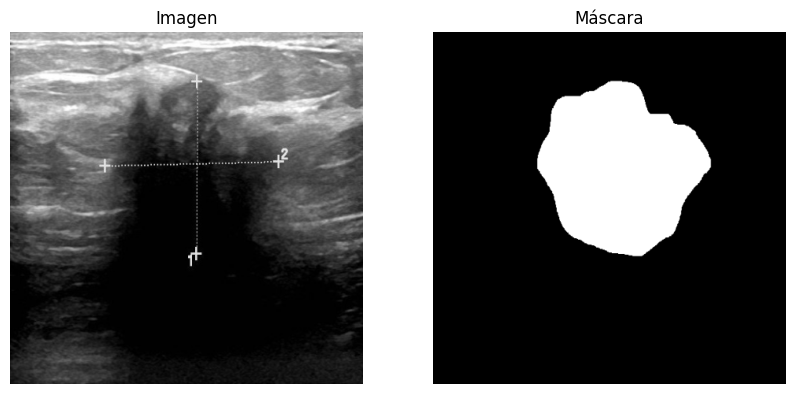

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


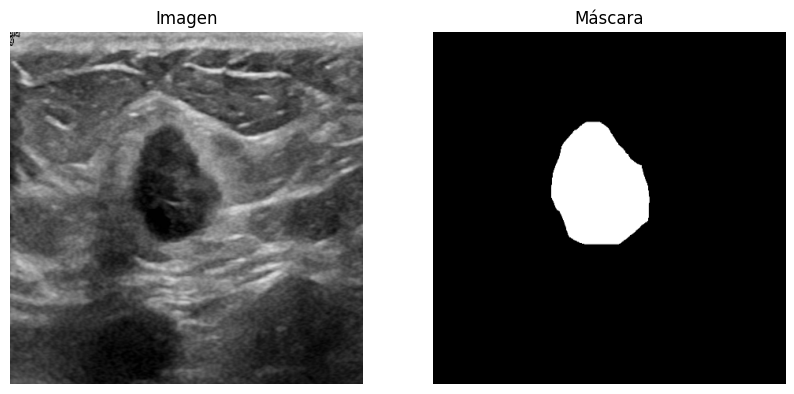

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


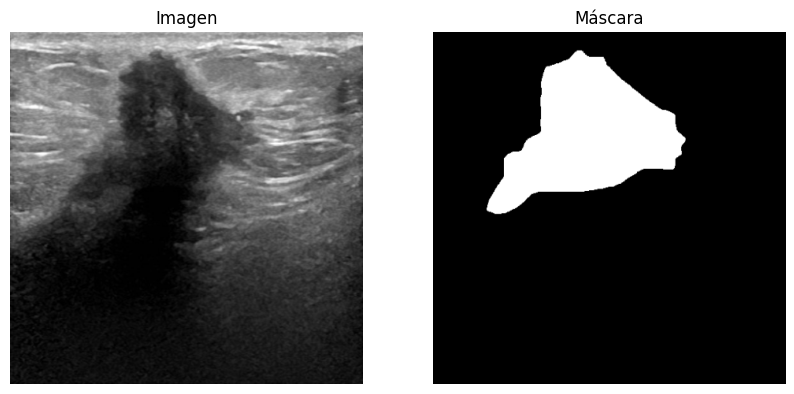

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


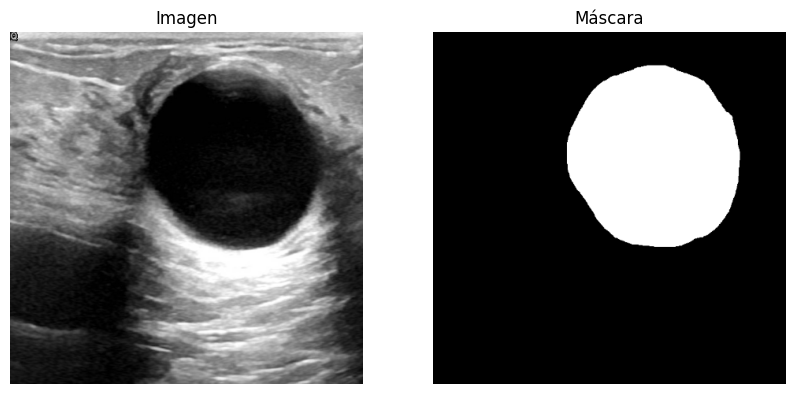

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


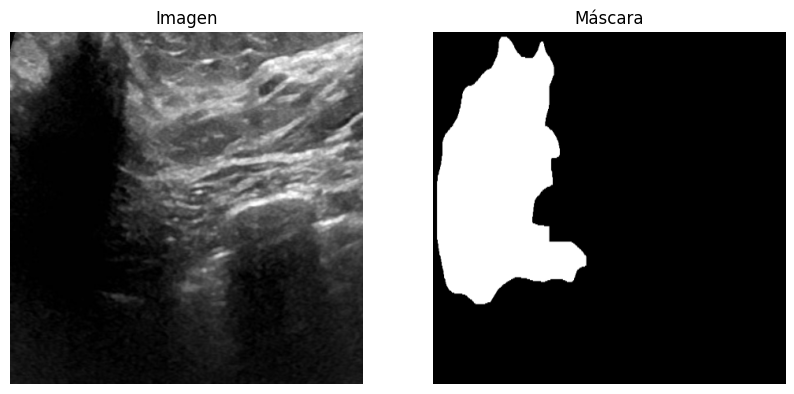

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


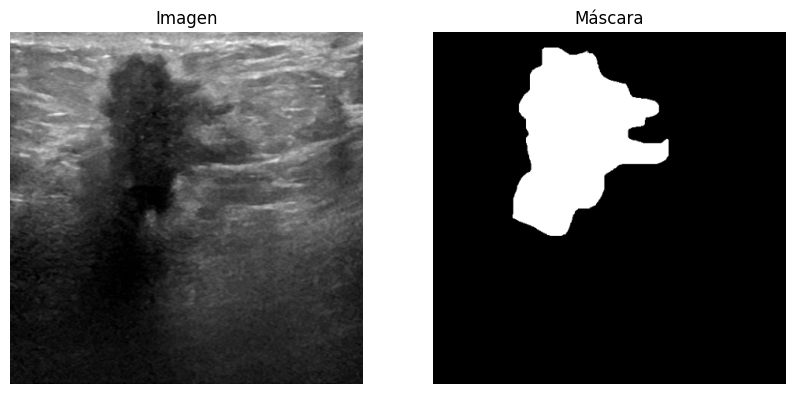

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


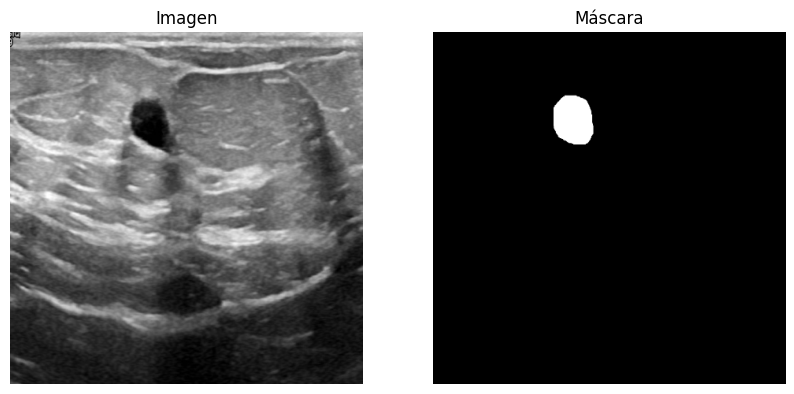

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


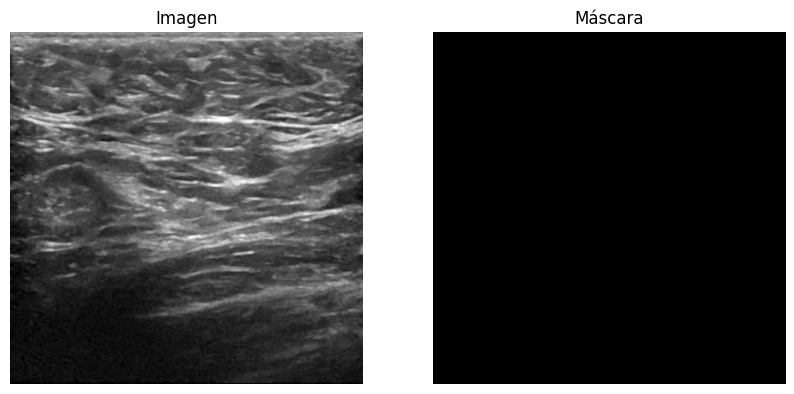

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


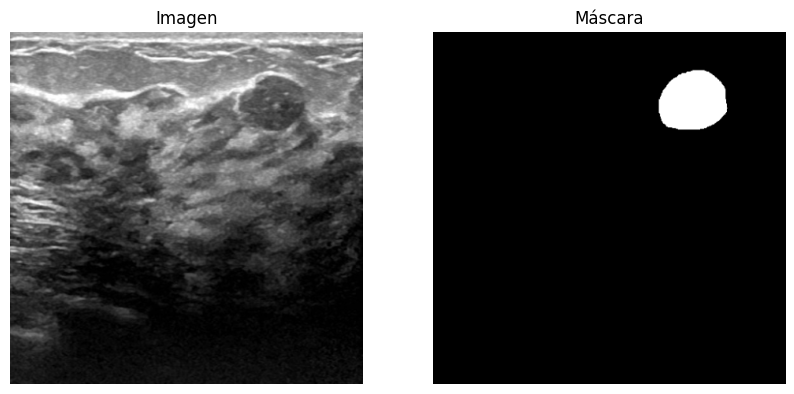

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


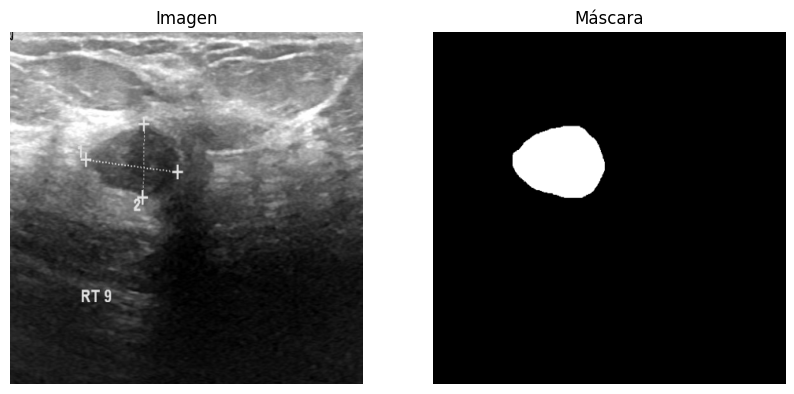

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


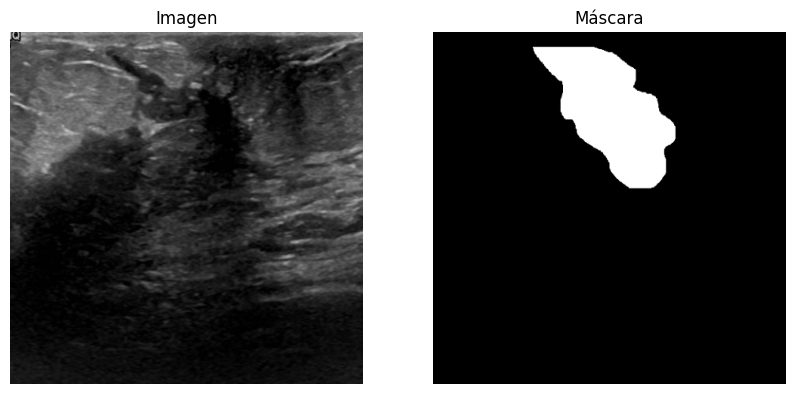

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


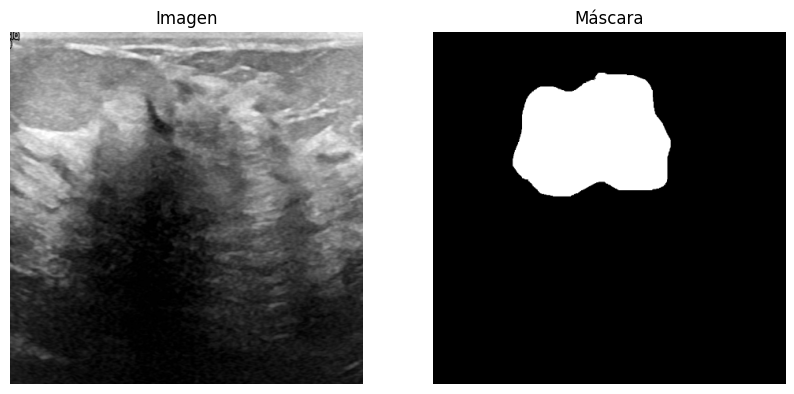

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


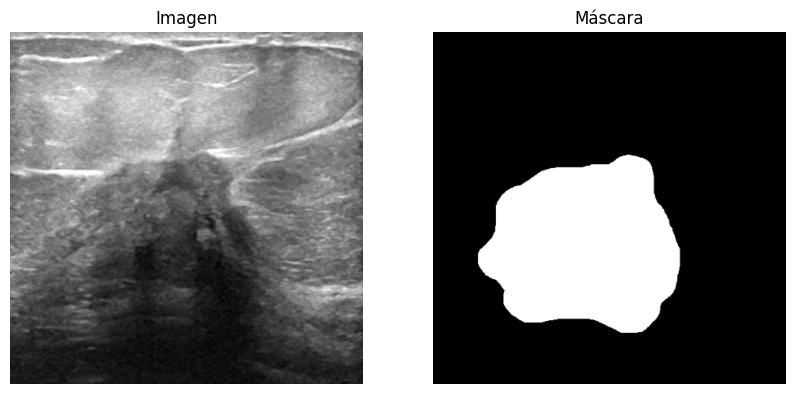

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


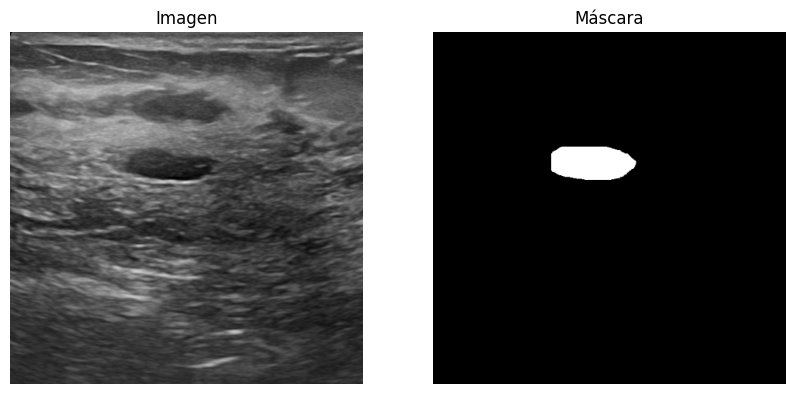

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


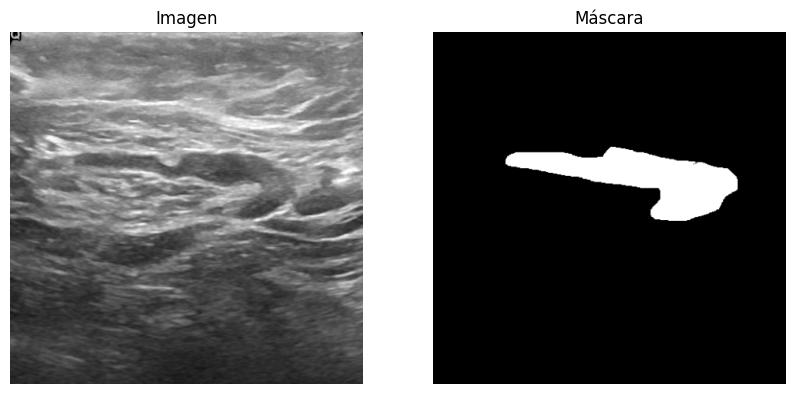

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


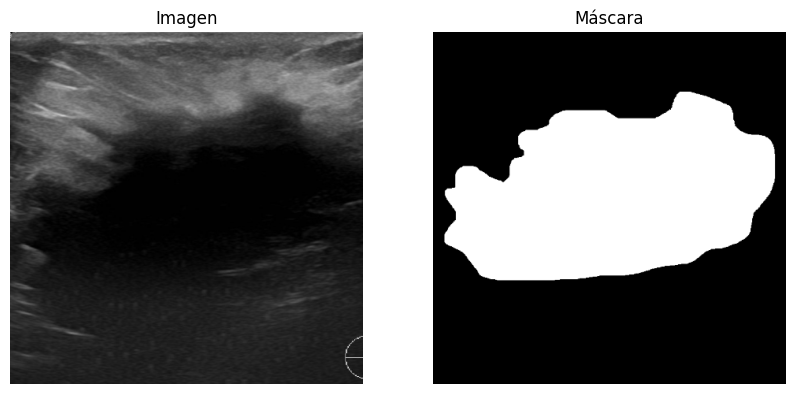

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


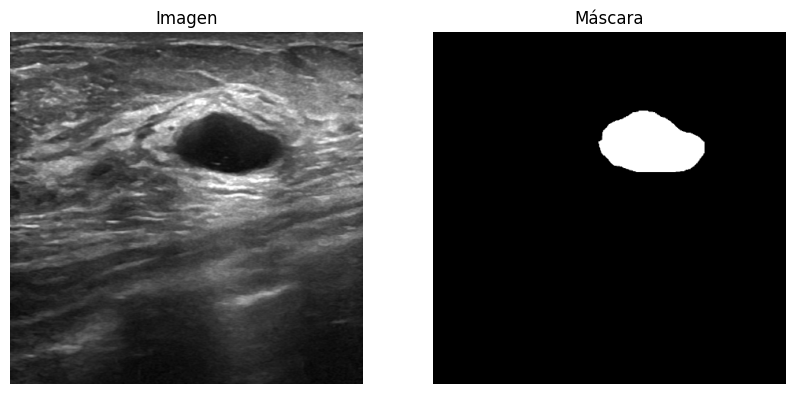

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


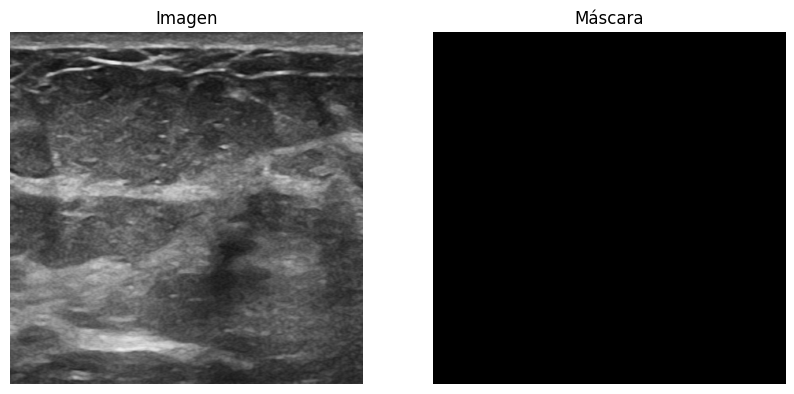

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


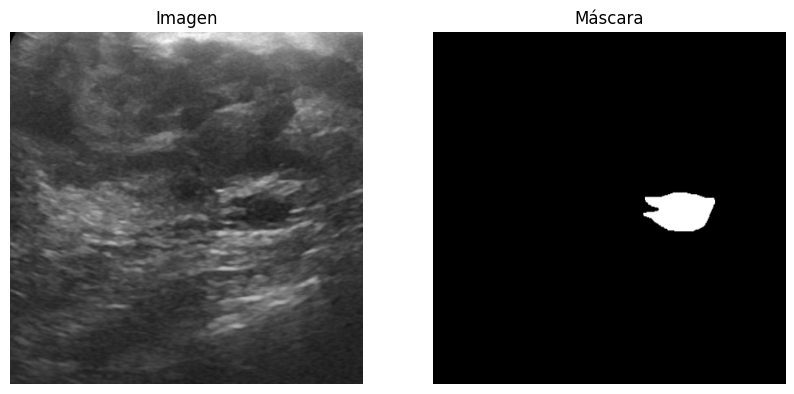

In [27]:
# Imprimir algunos ejemplos del conjunto de entrenamiento
num_examples_to_print = 19
for batch_image, batch_mask in train_dataset.take(1):  # Solo tomamos el primer lote
    for i in range(num_examples_to_print):
        # Extraer una imagen y su máscara del lote
        image = batch_image[i]
        mask = batch_mask[i]

        # Imprimir el tamaño de la imagen y la máscara
        print(f"Tamaño de la imagen: {image.shape}, Tamaño de la máscara: {mask.shape}")

        # Mostrar la imagen y la máscara utilizando matplotlib
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy())
        plt.title('Imagen')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy().squeeze(), cmap='gray')  # Squeeze para eliminar la dimensión de canal
        plt.title('Máscara')
        plt.axis('off')

        plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import backend as K
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

def build_model(num_classes):
    # Cargar el modelo preentrenado InceptionV3 sin las capas fully-connected
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # Congelar todas las capas del modelo preentrenado
    for layer in base_model.layers:
        layer.trainable = False

    # Agregar capas personalizadas al final del modelo
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Definir el nuevo modelo
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

    return model
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    # Compute the weighted F1 score
    weights = K.sum(y_true, axis=0) / K.sum(y_true)
    weighted_f1 = K.sum(weights * f1)

    return weighted_f1

# Definir el tamaño de entrada y el número de clases
input_shape = (img_width, img_height, n_channels)
num_classes = 3  # Normal, Benigno, Maligno
model = build_model(num_classes)

model.compile(loss='categorical_crossentropy',  # función de pérdida para problemas de clasificación multi-clase
              optimizer="adam",
              metrics=[f1_metric])

# Imprimir el resumen del modelo
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_752 (Conv2D)         (None, None, None, 32)       864       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_752 (B  (None, None, None, 32)       96        ['conv2d_752[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_752 (Activation  (None, None, None, 32)       0         ['batch_normalization_75

In [ ]:
early_stopping = EarlyStopping(monitor='val_f1_metric', patience=20, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_f1_metric', factor=0.2, patience=5, min_lr=0.00001)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose = 2,
    steps_per_epoch=np.ceil(len(dftrain) / batch_size),
    validation_steps=np.ceil(len(dfval) / batch_size),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30
7/7 - 9s - loss: 3.5615 - f1_metric: 0.3438 - val_loss: 1.1181 - val_f1_metric: 0.6461 - lr: 0.0010 - 9s/epoch - 1s/step
Epoch 2/30
7/7 - 1s - loss: 1.2442 - f1_metric: 0.6842 - val_loss: 0.5776 - val_f1_metric: 0.7371 - lr: 0.0010 - 1s/epoch - 213ms/step
Epoch 3/30
7/7 - 1s - loss: 0.5760 - f1_metric: 0.7431 - val_loss: 0.6007 - val_f1_metric: 0.6800 - lr: 0.0010 - 1s/epoch - 175ms/step
Epoch 4/30
7/7 - 1s - loss: 0.4460 - f1_metric: 0.8057 - val_loss: 0.5698 - val_f1_metric: 0.6889 - lr: 0.0010 - 1s/epoch - 210ms/step
Epoch 5/30
7/7 - 2s - loss: 0.3334 - f1_metric: 0.9068 - val_loss: 0.6033 - val_f1_metric: 0.6618 - lr: 0.0010 - 2s/epoch - 287ms/step
Epoch 6/30
7/7 - 2s - loss: 0.2801 - f1_metric: 0.9097 - val_loss: 0.6109 - val_f1_metric: 0.7031 - lr: 0.0010 - 2s/epoch - 282ms/step
Epoch 7/30
7/7 - 1s - loss: 0.2225 - f1_metric: 0.9413 - val_loss: 0.6040 - val_f1_metric: 0.7081 - lr: 2.0000e-04 - 1s/epoch - 209ms/step
Epoch 8/30
7/7 - 1s - loss: 0.2099 - f1_metric: 0.9478

In [ ]:
test_loss, test_medida = model.evaluate(test_dataset, verbose=2)
print("test_loss: %.4f, test_medida: %.4f" % (test_loss, test_medida))

3/3 - 0s - loss: 0.6312 - f1_metric: 0.7575 - 373ms/epoch - 124ms/step
test_loss: 0.6312, test_medida: 0.7575


In [ ]:
# Directorio donde se encuentran las imágenes de prueba
test_images_dir = 'test/images/'

# Obtener la lista de nombres de archivos de las imágenes de prueba
test_filenames = os.listdir(test_images_dir)

# Crear un DataFrame para almacenar las predicciones
predictions_df = pd.DataFrame({'image_filename': test_filenames})

# Crear columnas para 'normal', 'benign' y 'malignant' con valores iniciales de 0
predictions_df['normal'] = 0
predictions_df['benign'] = 0
predictions_df['malignant'] = 0

# Iterar sobre cada imagen de prueba
for filename in test_filenames:
    # Cargar la imagen y preprocesarla
    img_path = os.path.join(test_images_dir, filename)
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión adicional para el lote

    # Realizar la predicción
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Obtener la clase predicha

    # Actualizar las columnas correspondientes según la predicción
    if predicted_class == 0:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'normal'] = 1
    elif predicted_class == 1:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'benign'] = 1
    elif predicted_class == 2:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'malignant'] = 1

# Ordenar el DataFrame por el nombre del archivo de imagen
predictions_df = predictions_df.sort_values(by='image_filename')

# Guardar el DataFrame en un archivo CSV
predictions_df.to_csv('test_predictions.csv', index=False)

# Imprimir las primeras filas del DataFrame para verificar
print(predictions_df.head())


1/1 [==============================] - 0s 29ms/step
    image_filename  normal  benign  malignant
64   image_005.png       0       1          0
53   image_006.png       0       1          0
112  image_007.png       0       1          0
40   image_009.png       0       1          0
21   image_010.png       0       1          0
